In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.integrate import odeint
import pandas as pd
import math

In [ ]:
tauNbar=35; tauHPbar=1000; tauE=20; tauH=1; taurs=1500
thetaM=-35; thetaN=-25; sigmaM=-10; sigmaN=-8; thetaS=-30; sigmaS=-12
thetaMP=-40; sigmaMP=-6; thetaHP=-48; sigmaHP=6; thetaA=-20; sigmaA=-10
thetaE=-60; sigmaE=5; thetaaT = -65; sigmaaT = -7.8; thetabT = 0.4
sigmabT = -0.1; thetarT = -67; sigmarT = 2;  taur0 = 40; taur1 = 17.5
thrT = 68; sgmrt = 2.2; phirT=0.2; thetaRF=-105; sigmaRF=5; thetaRS=-105
sigmaRS=25; kr=0.3; prf=100; f=0.1; eps=0.0015; kca=0.3; ks=0.6

# --- Constants ---
Cm = 30.0  # pF
ENa = 50.0
EK = -90.0
EL = -70.0
EH = -30.0
RTF = 26.7
Ca_ex = 2.0


# --- Gating kinetics ---
def am(v):
    return 0.1 * (v + 30) / (1 - np.exp(-(v + 30)/10))

def bm(v):
    return 4 * np.exp(-0.0556 * (v + 60))

def ah(v):
    return 0.128 * np.exp(-(v + 60)/20)

def bh(v):
    return 4 / (1 + np.exp(-(v + 27)/5))

def an(v):
  k1 = 0.005
  k2= 45
  k3 = 8
  k4 = 80
  k5 = 50
  return k1*(v+k2)/(1-np.exp(-(v+k2)/k3))

def bn(v):
    return 0.125 * np.exp(-(v + 80)/50)

def sinf(v):
  return 1/(1+np.exp((v-thetaS)/sigmaS))

def kinf(ca):
  return (ca**2)/(ca**2+(ks**2))

def aTinf(v):
  return 1/(1+np.exp((v-thetaaT)/sigmaaT))

def bTinf(v,rT):
  return 1/(1+np.exp((rT-thetabT)/sigmabT))-1/(1+np.exp(-thetabT/sigmabT))

def rTinf(v):
  return 1/(1+np.exp((v-thetarT)/sigmarT))

def taurT(v):
  return taur0+taur1/(1+np.exp((v-thrT)/sgmrt))

def mpinf(v):
  return 1/(1+np.exp((v-thetaMP)/sigmaMP))

def hpinf(v):
  return 1/(1+np.exp((v-thetaHP)/sigmaHP))

def tauhp(v):
  return tauHPbar/np.cosh((v-thetaHP)/(2*sigmaHP))

def rinff(v):
  return 1/(1+np.exp((v-thetaRF)/sigmaRF))

def rinfs(v):
  return 1/(1+np.exp((v-thetaRS)/sigmaRS))

def taurf(v):
  return prf/(-7.4*(v+70)/(np.exp(-(v+70)/0.8)-1)+65*np.exp(-(v+56)/23))

def ainf(v):
  return 1/(1+np.exp((v-thetaA)/sigmaA))

def einf(v):
  return 1/(1+np.exp((v-thetaE)/sigmaE))

def minf(v):
  return  1/(1+np.exp((v-thetaM)/sigmaM))






In [ ]:
dataframe=pd.read_csv('wow.csv')
dataframe.head()

,n,h,rf,rs,ca,v,e,rT,hp
0,0.000200,0.010000,0.030000,0.030000,0.103000,-70.140000,0.050000,0.010000,0.100000
1,0.000207,0.029567,0.029279,0.030002,0.103010,-70.136158,0.050833,0.010057,0.100057
2,0.000213,0.048747,0.028576,0.030004,0.103021,-70.131573,0.051666,0.010114,0.100114
3,0.000219,0.067547,0.027890,0.030007,0.103031,-70.124280,0.052497,0.010171,0.100170
4,0.000225,0.085974,0.027221,0.030009,0.103042,-70.115988,0.053327,0.010227,0.100227


In [ ]:
I=np.loadtxt('nidaq_Dev1_ai-00045_current.txt')
V_data=np.loadtxt('nidaq_Dev1_ai-00045_voltage.txt')

In [ ]:
import pandas as pd

# Extract each column into a separate variable
v = dataframe.iloc[:, 5].to_numpy()
n = dataframe.iloc[:, 0].to_numpy()
h = dataframe.iloc[:, 1].to_numpy()
rf = dataframe.iloc[:, 2].to_numpy()
rs = dataframe.iloc[:, 3].to_numpy()
ca = dataframe.iloc[:, 4].to_numpy()
e= dataframe.iloc[:, 6].to_numpy()
rT= dataframe.iloc[:, 7].to_numpy()
hp= dataframe.iloc[:, 8].to_numpy()



In [ ]:
print(v)

[-70.14       -70.13615776 -70.13157275 ... -55.84824258 -55.84653767
 -55.84442645]


In [ ]:
sample_rate = 50000
# Generate time values based on the sampling rate
num_samples = len(I)
t = np.arange(num_samples) / sample_rate

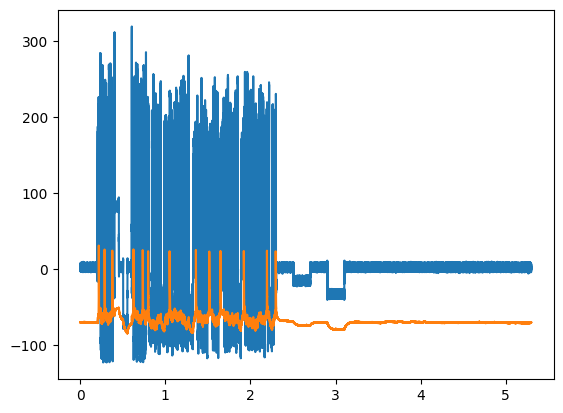

In [ ]:
plt.plot(t,I)
plt.plot(t,V_data)
plt.show()

In [ ]:
def compute_dVdt(V, dt):
    dVdt = np.gradient(V, dt)
    return dVdt.reshape(-1,1)

In [ ]:
dt = 1.0 / sample_rate

In [ ]:
dvdt=compute_dVdt(V_data,1)
print(dvdt)

[[ 0.1831  ]
 [-0.11444 ]
 [-0.053405]
 ...
 [-0.106815]
 [ 0.20599 ]
 [ 0.36621 ]]


In [ ]:
def build_sindy_library(V, m, h, n, ca, e, rf, rs, rT, hp,I_app):
   gNa=100
   gK=60
   gSK=4
   gCaT=0.1
   gCa=20
   gH=4
   gNa1=gNa*(m**3)*h
   gK1=gK*(n**4)
   gbarl=2
   gl=2
   gNap=1
   gA=1

   INa=gNa1*(v-ENa)
   IK=gK1*(v-EK)
   Il=gl*(v-EL)

# ---L-Type Ca++ Equations and Current----
   iCa = gCa*(sinf(V)**2)*v*(Ca_ex/(1-np.exp((2*v)/RTF)))
# ---SK Equations and Current----
   iSK = gSK*kinf(ca)*(v-EK)


# ---T-Type Ca++ Equations and Current----
   iT=gCaT*(aTinf(V)**3)*(bTinf(V,rT)**3)*v*(Ca_ex/(1-np.exp((2*v)/RTF)))


# ---Na+ Persistant Current and Equations----
   iNap = gNap*mpinf(V)*hp*(v-ENa)


#---Hyperpolarization activated inward current Ih---
   iH = gH*(kr*rf+(1-kr)*rs)*(v-EH)


#---- A-type potassium current Ia----
   iA = gA*ainf(V)*e*(v-EK)

   Theta = np.column_stack([V_data, I_app, INa, IK, Il, iCa, iSK, iA, iH, iNap, iT])

   return Theta

In [ ]:
pip install pysindy

In [ ]:
import pysindy as ps

In [ ]:
# --- Build library and compute dVdt
m=minf(V_data)
Theta = build_sindy_library(V_data, m, h, n, ca, e, rf, rs, rT,hp, I)
dVdt = compute_dVdt(V_data, dt)

# --- Fit SINDy
optimizer = ps.STLSQ(threshold=0.01)
model = ps.SINDy(
    optimizer=optimizer,
    feature_library=ps.IdentityLibrary(),
    feature_names=[
        'V','I_app', 'I_Na', 'I_K', 'I_Leak', 'I_CaL', 'I_SK', 'I_A', 'I_H','INap', 'I_T'
    ]
)



In [ ]:
len(I)

265000

In [ ]:
model.fit(Theta, t=dt, x_dot=dVdt)

# --- Print discovered model
model.print()

(V)' = -0.862 V + 12.465 I_app + 0.967 I_Na + 1.097 I_K + -6.023 I_Leak + 5.579 I_CaL + -12.855 I_SK + 778.173 I_A + -17.728 I_H + -56.425 INap + 1154.650 I_T


In [ ]:
import numpy as np
import torch

# --- Load .txt files ---
V_exp = np.loadtxt('nidaq_Dev1_ai-00045_voltage.txt')
I_inj = np.loadtxt('nidaq_Dev1_ai-00045_current.txt')

# If you have no time file, recreate it
dt = 0.1  # for example, sampling every 0.1 ms
t = np.arange(0, len(V_exp) * dt, dt)

# Convert to torch tensors
t = torch.tensor(t, dtype=torch.float64)
V_exp = torch.tensor(V_exp, dtype=torch.float64)
I_inj = torch.tensor(I_inj, dtype=torch.float64)


In [ ]:
# --- Imports ---
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# --- Define the full PINN_multi class ---
class PINN_multi(nn.Module):
    def __init__(self, t, V_exp, iapplied, layers_struc, lb, ub, device='cpu'):
        super(PINN_multi, self).__init__()
        self.dev = device

        # Data
        self.t = torch.tensor(t, dtype=torch.float64, requires_grad=True, device=device).unsqueeze(-1)
        self.V_exp = torch.tensor(V_exp, dtype=torch.float64, device=device).unsqueeze(-1)
        self.input_train = torch.cat([self.t, self.V_exp], dim=1).requires_grad_()

        self.iapplied = torch.tensor(iapplied, dtype=torch.float64, device=device).unsqueeze(-1)

        self.lb = torch.tensor(lb, device=device)
        self.ub = torch.tensor(ub, device=device)

        # Capacitance
        self.C = 36  # 30 pF converted to Farads

        # Build Networks
        self.layers_struc = layers_struc
        self.net_vars = nn.ModuleDict({var: self.build_net(layers_struc) for var in ['n', 'h', 'rf', 'rs', 'ca', 'v', 'e', 'rT', 'hp']})

        # Learnable Conductances
        self.gNa_ = nn.Parameter(torch.tensor(120.0, dtype=torch.float64, device=device))
        self.gK_ = nn.Parameter(torch.tensor(36.0, dtype=torch.float64, device=device))
        self.gCa_ = nn.Parameter(torch.tensor(1.0, dtype=torch.float64, device=device))
        self.gCaT_ = nn.Parameter(torch.tensor(2.0, dtype=torch.float64, device=device))
        self.gNap_ = nn.Parameter(torch.tensor(0.07, dtype=torch.float64, device=device))
        self.gSK_ = nn.Parameter(torch.tensor(2.5, dtype=torch.float64, device=device))
        self.gH_ = nn.Parameter(torch.tensor(0.1, dtype=torch.float64, device=device))
        self.gL_ = nn.Parameter(torch.tensor(0.3, dtype=torch.float64, device=device))

        # Reversal Potentials (fixed)
        self.ENa_, self.EK_, self.EL_, self.EH_ = 50.0, -90.0, -70.0, -30.0
        self.RTF = 26.7
        self.Ca_ex = 2.0
        self.ECa_ = self.RTF * np.log(self.Ca_ex / (0.0001))  # calcium reversal potential

        # Other parameters you provided
        self.tauNbar, self.tauHPbar, self.tauEbar, self.tauHbar, self.taursbar = 35, 1000, 20, 1, 1500
        self.thetaM, self.sigmaM = -35, -10
        self.thetaN, self.sigmaN = -25, -8
        self.thetaS, self.sigmaS = -30, -12
        self.thetaMP, self.sigmaMP = -40, -6
        self.thetaHP, self.sigmaHP = -48, 6
        self.thetaA, self.sigmaA = -20, -10
        self.thetaE, self.sigmaE = -60, 5
        self.thetaaT, self.sigmaaT = -65, -7.8
        self.thetabT, self.sigmabT = 0.4, -0.1
        self.thetarT, self.sigmarT = -67, 2
        self.taur0, self.taur1 = 40, 17.5
        self.thrT, self.sgmrt = 68, 2.2
        self.phirT_ = 0.2
        self.thetaRF, self.sigmaRF = -105, 5
        self.thetaRS, self.sigmaRS = -105, 25
        self.kr_value, self.prf, self.f_value, self.eps_value, self.kca_value, self.ks = 0.3, 100, 0.1, 0.0015, 0.3, 0.6

        # Optimizers
        self.optimizer = torch.optim.LBFGS(self.parameters(), max_iter=50000, tolerance_grad=1e-10, line_search_fn='strong_wolfe')
        self.adam_optimizer = torch.optim.Adam(self.parameters())

        # Loss History
        self.lossHist = []

    def build_net(self, layers_struc):
        layers = [nn.Sequential(nn.Linear(i, o), nn.Tanh()).double() for i, o in zip(layers_struc[:-1], layers_struc[1:-1])]
        layers.append(nn.Linear(layers_struc[-2], 1))
        return nn.Sequential(*layers).double().to(self.dev)

    def forward(self, input):
        return {var: net(input) for var, net in self.net_vars.items()}

    def net_f(self, input):
        preds = self.forward(input)
        n, h, rf, rs, ca, v, e, rT, hp = preds['n'], preds['h'], preds['rf'], preds['rs'], preds['ca'], preds['v'], preds['e'], preds['rT'], preds['hp']

        def grad(var):
            return torch.autograd.grad(var, input, grad_outputs=torch.ones_like(var), retain_graph=True, create_graph=True)[0]

        n_t, h_t, rf_t, rs_t, ca_t, v_t, e_t, rT_t, hp_t = map(grad, (n, h, rf, rs, ca, v, e, rT, hp))

        ninf, tauN = self.n_inf(v), self.tau_n(v)
        hinf, tauH = self.h_inf(v), self.tau_h(v)
        rinff, taurf = self.rf_inf(v), self.tau_rf(v)
        rinfs, taurs = self.rs_inf(v), self.tau_rs(v)
        einf, tauE = self.e_inf(v), self.tau_e(v)
        rTinf, taurT = self.rT_inf(v), self.tau_rT(v)
        hpinf, tauhp = self.hp_inf(v), self.tau_hp(v)

        iNa = self.gNa() * (self.m_inf(v)**3) * h * (v - self.ENa())
        iK = self.gK() * (n**4) * (v - self.EK())
        iCa = self.gCa() * (self.s_inf(v)**2) * v * (self.Ca_drive(v))
        iT = self.gCaT() * (self.aT_inf(v)**3) * (self.bT_inf(v, rT)**3) * v * (self.Ca_drive(v))
        iSK = self.gSK() * self.k_inf(ca) * (v - self.EK())
        iNap = self.gNap() * self.mp_inf(v) * hp * (v - self.ENa())
        iH = self.gH() * (self.kr() * rf + (1 - self.kr()) * rs) * (v - self.EH())
        iL = self.gl() * (v - self.EL())

        Itotal = iNa + iK + iCa + iT + iSK + iNap + iH + iL

        f_n = n_t - (ninf - n) / tauN
        f_h = h_t - (hinf - h) / tauH
        f_rf = rf_t - (rinff - rf) / taurf
        f_rs = rs_t - (rinfs - rs) / taurs
        f_ca = ca_t + self.f() * (self.eps() * (iCa + iT) + self.kca() * (ca - 0.1))
        f_v = v_t - (-Itotal + self.iapplied) / self.C
        f_rT = rT_t - self.phi_rT() * (rTinf - rT) / taurT
        f_hp = hp_t - (hpinf - hp) / tauhp

        return preds, f_n, f_h, f_rf, f_rs, f_ca, f_v, f_rT, f_hp

    def loss_fn(self, preds, *physics_terms):
        loss = nn.MSELoss()
        MSE_v = loss(preds['v'], self.V_exp)
        physics_loss = sum(loss(term, torch.zeros_like(term)) for term in physics_terms)
        return MSE_v + physics_loss

    def train_adam(self, iterations):
        for it in range(iterations):
            preds, *physics = self.net_f(torch.cat([self.t, self.V_exp], dim=1))
            loss = self.loss_fn(preds, *physics)
            loss.backward(retain_graph=True)
            self.adam_optimizer.step()
            self.adam_optimizer.zero_grad()
            if (it % 10) == 0:
                print(f"Iteration {it}, Loss: {loss.item():.3e}")
                self.lossHist.append(loss.item())

    def train_lbfgs(self):
      def closure():
        self.optimizer.zero_grad()
        preds, *physics = self.net_f(self.input_train)
        loss = self.loss_fn(preds, *physics)
        loss.backward(retain_graph=True)
        self.lossHist.append(loss.item())
        return loss
      self.optimizer.step(closure)


    def train_model(self, adam_it):
        self.train_adam(adam_it)
        # --- Print conductances after Adam ---
        print("\nConductances after Adam optimizer:")
        print(f"gNa  = {self.gNa().item():.6f}")
        print(f"gK   = {self.gK().item():.6f}")
        print(f"gCa  = {self.gCa().item():.6f}")
        print(f"gCaT = {self.gCaT().item():.6f}")
        print(f"gSK  = {self.gSK().item():.6f}")
        print(f"gNap = {self.gNap().item():.6f}")
        print(f"gH   = {self.gH().item():.6f}")
        print(f"gL   = {self.gl().item():.6f}")

        # --- Train with LBFGS optimizer ---
        self.train_lbfgs()

        print("\nTraining completely over!")


    # --- Gating kinetics ---
    def n_inf(self, v): return 1 / (1 + torch.exp(-(v + 35) / 10))
    def tau_n(self, v): return self.tauNbar
    def h_inf(self, v): return 1 / (1 + torch.exp((v + 55) / 7))
    def tau_h(self, v): return self.tauHbar
    def m_inf(self, v): return 1 / (1 + torch.exp((v - self.thetaM) / self.sigmaM))
    def s_inf(self, v): return 1 / (1 + torch.exp((v - self.thetaS) / self.sigmaS))
    def k_inf(self, ca): return (ca**2) / (ca**2 + self.ks**2)
    def aT_inf(self, v): return 1 / (1 + torch.exp((v - self.thetaaT) / self.sigmaaT))
    def bT_inf(self, v, rT):
        thetabT = torch.tensor(self.thetabT, dtype=torch.float64, device=self.dev)
        sigmabT = torch.tensor(self.sigmabT, dtype=torch.float64, device=self.dev)
        return (1 / (1 + torch.exp((rT - thetabT) / sigmabT))) - (1 / (1 + torch.exp(-thetabT / sigmabT)))

    def Ca_drive(self, v): return (1 - torch.exp(-2 * v / 25)) / v
    def e_inf(self, v): return 1 / (1 + torch.exp((v - self.thetaE) / self.sigmaE))
    def mp_inf(self, v): return 1 / (1 + torch.exp((v - self.thetaMP) / self.sigmaMP))
    def hp_inf(self, v): return 1 / (1 + torch.exp((v - self.thetaHP) / self.sigmaHP))
    def tau_hp(self, v): return self.tauHPbar / torch.cosh((v - self.thetaHP) / (2 * self.sigmaHP))
    def rf_inf(self, v): return 1 / (1 + torch.exp((v - self.thetaRF) / self.sigmaRF))
    def rs_inf(self, v): return 1 / (1 + torch.exp((v - self.thetaRS) / self.sigmaRS))
    def tau_rf(self, v): return self.prf / (-7.4*(v+70)/(torch.exp(-(v+70)/0.8)-1) + 65*torch.exp(-(v+56)/23))
    def tau_rs(self, v): return self.prf / (-7.4*(v+70)/(torch.exp(-(v+70)/0.8)-1) + 65*torch.exp(-(v+56)/23))
    def rT_inf(self, v): return 1 / (1 + torch.exp((v - self.thrT) / self.sgmrt))
    def tau_rT(self, v): return self.taur0 + self.taur1 / (1 + torch.exp((v - self.thrT) / self.sgmrt))
    def phi_rT(self): return self.phirT_
    def tau_e(self, v):
        return self.tauEbar  # 20 ms

    def gNa(self): return self.gNa_
    def gK(self): return self.gK_
    def gCa(self): return self.gCa_
    def gCaT(self): return self.gCaT_
    def gNap(self): return self.gNap_
    def gSK(self): return self.gSK_
    def gH(self): return self.gH_
    def gl(self): return self.gL_
    def ENa(self): return self.ENa_
    def EK(self): return self.EK_
    def EL(self): return self.EL_
    def EH(self): return self.EH_
    def f(self): return self.f_value
    def eps(self): return self.eps_value
    def kca(self): return self.kca_value
    def kr(self): return self.kr_value


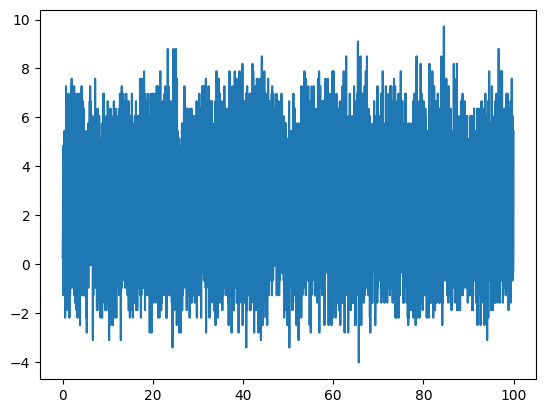

In [ ]:
#plt.plot(t_data,v_data)
plt.plot(t_data,i_data)

In [ ]:
import numpy as np

sampling_rate = 50000  # Hz
dt = 1000 / sampling_rate  # ms (because 1 sec = 1000 ms)

n_samples = 20000  # How many points you're using
t_numpy = np.arange(0, n_samples * dt, dt)  # Time vector
t_numpy = t_numpy[:n_samples]
t_data=t_numpy

In [ ]:
# --- Imports ---
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Load your real data ---
v_data = np.loadtxt('nidaq_Dev1_ai-00045_voltage.txt')      # Voltage trace
i_data = np.loadtxt('nidaq_Dev1_ai-00045_current.txt')   # Injected current trace

# --- Take only 20000 points ---
v_data = v_data[:20000]
i_data = i_data[:20000]

# --- Model settings ---
layers_struc = [2, 50, 50, 50, 1]  # (t, v) --> hidden --> output
lb = [t_data.min(), v_data.min()]
ub = [t_data.max(), v_data.max()]

# --- Instantiate the model ---
model = PINN_multi(t_data, v_data, i_data, layers_struc, lb, ub, device='cpu')  # or device='cuda'

# --- Train model ---
print("\nStarting training on real data...")
model.train_model(adam_it=20000)

# --- Plot training loss ---
plt.figure(figsize=(8, 5))
plt.plot(model.lossHist)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss History (Real Data)')
plt.grid(True)
plt.show()

# --- Print learned conductances ---
print("\nLearned Conductances after Training:")
print(f"gNa  = {model.gNa().item():.4f}")
print(f"gK   = {model.gK().item():.4f}")
print(f"gCa  = {model.gCa().item():.4f}")
print(f"gCaT = {model.gCaT().item():.4f}")
print(f"gNap = {model.gNap().item():.4f}")
print(f"gSK  = {model.gSK().item():.4f}")
print(f"gH   = {model.gH().item():.4f}")
print(f"gL   = {model.gl().item():.4f}")


Starting training on real data...
Iteration 0, Loss: 4.403e+03
Iteration 10, Loss: 4.161e+03
Iteration 20, Loss: 4.014e+03
Iteration 30, Loss: 3.878e+03
Iteration 40, Loss: 3.761e+03
Iteration 50, Loss: 3.663e+03
Iteration 60, Loss: 3.578e+03
Iteration 70, Loss: 3.501e+03
Iteration 80, Loss: 3.428e+03
Iteration 90, Loss: 3.360e+03
Iteration 100, Loss: 3.294e+03
Iteration 110, Loss: 3.230e+03
Iteration 120, Loss: 3.168e+03
Iteration 130, Loss: 3.108e+03
Iteration 140, Loss: 3.050e+03
Iteration 150, Loss: 2.992e+03
Iteration 160, Loss: 2.937e+03
Iteration 170, Loss: 2.882e+03
Iteration 180, Loss: 2.828e+03
Iteration 190, Loss: 2.776e+03
Iteration 200, Loss: 2.725e+03
Iteration 210, Loss: 2.674e+03
Iteration 220, Loss: 2.625e+03
Iteration 230, Loss: 2.576e+03
Iteration 240, Loss: 2.528e+03
Iteration 250, Loss: 2.481e+03
Iteration 260, Loss: 2.435e+03
Iteration 270, Loss: 2.390e+03
Iteration 280, Loss: 2.345e+03
Iteration 290, Loss: 2.302e+03
Iteration 300, Loss: 2.259e+03
Iteration 310, 

Voltage MSE: 0.182931


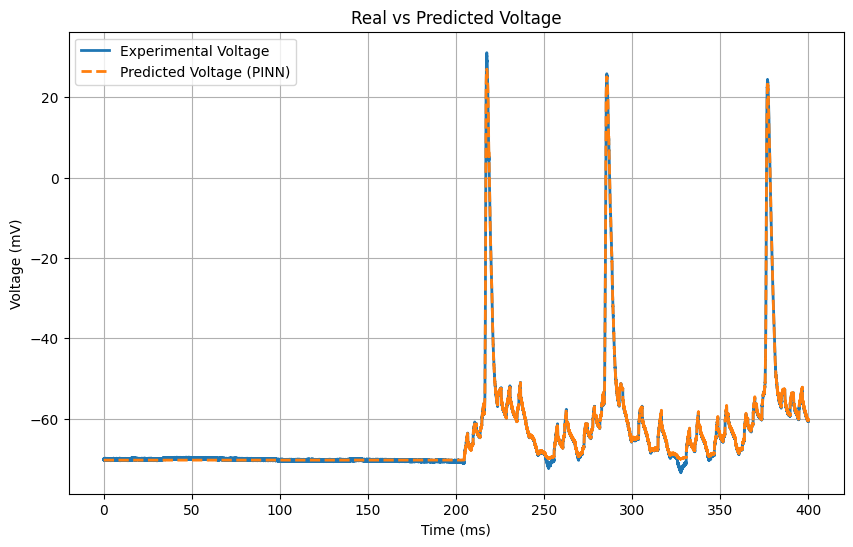

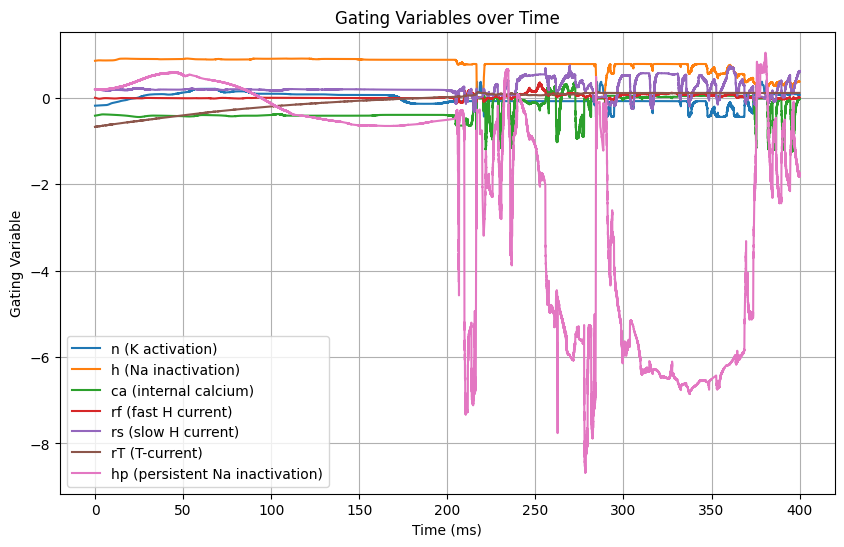

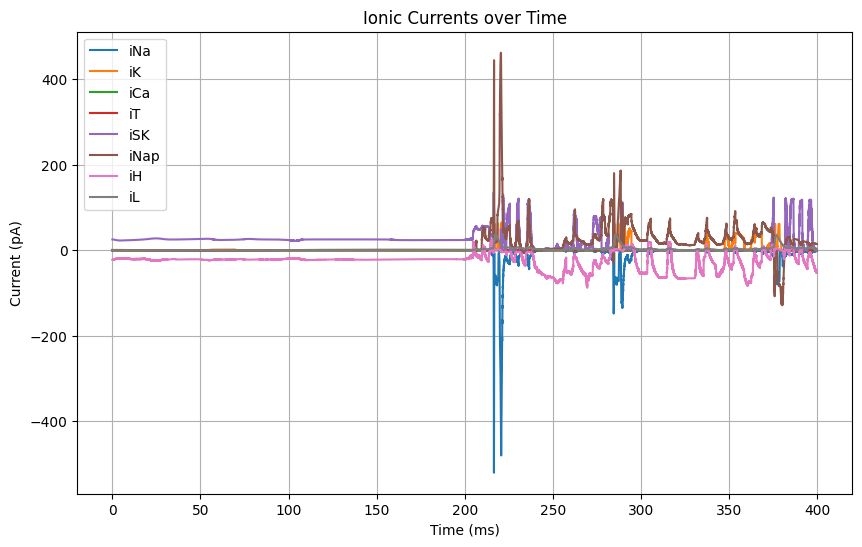

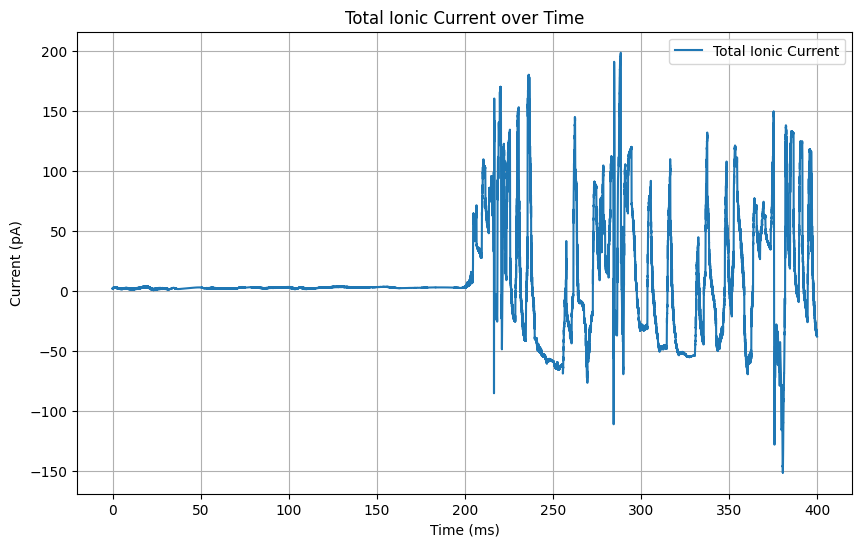

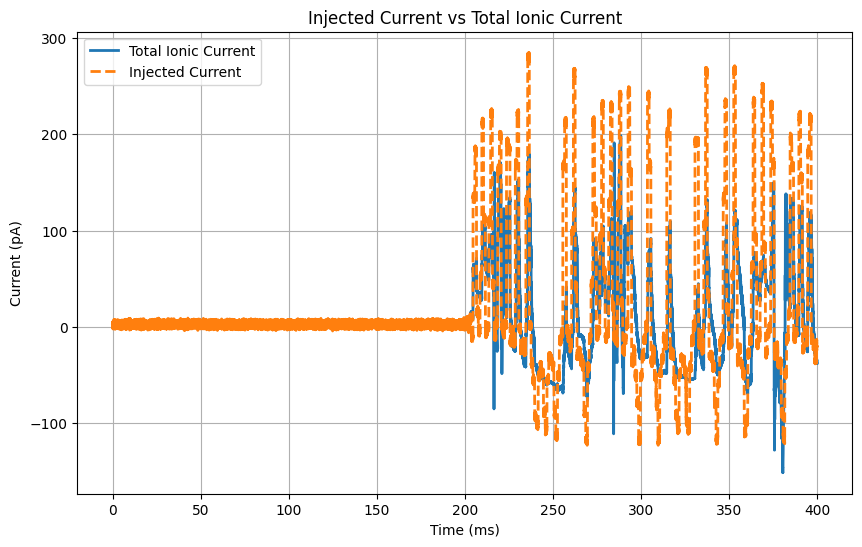

In [ ]:
# Get model predictions on training data
model.eval()  # Set model to evaluation mode (important)

with torch.no_grad():  # No need for gradient during prediction
    preds = model.forward(model.input_train)
    v_pred = preds['v'].cpu().numpy().flatten()
from sklearn.metrics import mean_squared_error

mse_v = mean_squared_error(model.V_exp.cpu().numpy(), v_pred)
print(f"Voltage MSE: {mse_v:.6f}")
# --- Set model to evaluation ---
# --- Set model to evaluation ---
model.eval()

with torch.no_grad():
    preds = model.forward(model.input_train)
    n_pred = preds['n'].cpu().numpy().flatten()
    h_pred = preds['h'].cpu().numpy().flatten()
    rf_pred = preds['rf'].cpu().numpy().flatten()
    rs_pred = preds['rs'].cpu().numpy().flatten()
    ca_pred = preds['ca'].cpu().numpy().flatten()
    v_pred = preds['v'].cpu().numpy().flatten()
    e_pred = preds['e'].cpu().numpy().flatten()
    rT_pred = preds['rT'].cpu().numpy().flatten()
    hp_pred = preds['hp'].cpu().numpy().flatten()

# --- Recalculate currents using predicted variables ---
t_numpy = model.t.detach().cpu().numpy().flatten()


# Convert to torch tensors for current calculation
v_tensor = torch.tensor(v_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
n_tensor = torch.tensor(n_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
h_tensor = torch.tensor(h_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
rf_tensor = torch.tensor(rf_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
rs_tensor = torch.tensor(rs_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
ca_tensor = torch.tensor(ca_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
rT_tensor = torch.tensor(rT_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
hp_tensor = torch.tensor(hp_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)

# Calculate currents
iNa = model.gNa() * (model.m_inf(v_tensor)**3) * h_tensor * (v_tensor - model.ENa())
iK = model.gK() * (n_tensor**4) * (v_tensor - model.EK())
iCa = model.gCa() * (model.s_inf(v_tensor)**2) * v_tensor * model.Ca_drive(v_tensor)
iT = model.gCaT() * (model.aT_inf(v_tensor)**3) * (model.bT_inf(v_tensor, rT_tensor)**3) * v_tensor * model.Ca_drive(v_tensor)
iSK = model.gSK() * model.k_inf(ca_tensor) * (v_tensor - model.EK())
iNap = model.gNap() * model.mp_inf(v_tensor) * hp_tensor * (v_tensor - model.ENa())
iH = model.gH() * (model.kr() * rf_tensor + (1 - model.kr()) * rs_tensor) * (v_tensor - model.EH())
iL = model.gl() * (v_tensor - model.EL())

# Convert currents to numpy for plotting
iNa = iNa.detach().cpu().numpy().flatten()
iK = iK.detach().cpu().numpy().flatten()
iCa = iCa.detach().cpu().numpy().flatten()
iT = iT.detach().cpu().numpy().flatten()
iSK = iSK.detach().cpu().numpy().flatten()
iNap = iNap.detach().cpu().numpy().flatten()
iH = iH.detach().cpu().numpy().flatten()
iL = iL.detach().cpu().numpy().flatten()


Itotal = iNa + iK + iCa + iT + iSK + iNap + iH + iL
# --- Plotting ---

import matplotlib.pyplot as plt

# 1. Plot Real vs Predicted Voltage
plt.figure(figsize=(10,6))
plt.plot(t_numpy, model.V_exp.detach().cpu().numpy().flatten(), label='Experimental Voltage', linewidth=2)
plt.plot(t_numpy, v_pred, '--', label='Predicted Voltage (PINN)', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Real vs Predicted Voltage')
plt.legend()
plt.grid(True)
plt.show()

# 2. Plot Gating Variables
plt.figure(figsize=(10,6))
plt.plot(t_numpy, n_pred, label='n (K activation)')
plt.plot(t_numpy, h_pred, label='h (Na inactivation)')
plt.plot(t_numpy, ca_pred, label='ca (internal calcium)')
plt.plot(t_numpy, rf_pred, label='rf (fast H current)')
plt.plot(t_numpy, rs_pred, label='rs (slow H current)')
plt.plot(t_numpy, rT_pred, label='rT (T-current)')
plt.plot(t_numpy, hp_pred, label='hp (persistent Na inactivation)')
plt.xlabel('Time (ms)')
plt.ylabel('Gating Variable')
plt.title('Gating Variables over Time')
plt.legend()
plt.grid(True)
plt.show()

# 3. Plot Each Ionic Current
plt.figure(figsize=(10,6))
plt.plot(t_numpy, iNa, label='iNa')
plt.plot(t_numpy, iK, label='iK')
plt.plot(t_numpy, iCa, label='iCa')
plt.plot(t_numpy, iT, label='iT')
plt.plot(t_numpy, iSK, label='iSK')
plt.plot(t_numpy, iNap, label='iNap')
plt.plot(t_numpy, iH, label='iH')
plt.plot(t_numpy, iL, label='iL')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Ionic Currents over Time')
plt.legend()
plt.grid(True)
plt.show()

# 4. Plot Total Current
plt.figure(figsize=(10,6))
plt.plot(t_numpy, Itotal, label='Total Ionic Current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Total Ionic Current over Time')
plt.legend()
plt.grid(True)
plt.show()
I_applied = model.iapplied.detach().cpu().numpy().flatten()

plt.figure(figsize=(10,6))
plt.plot(t_numpy, Itotal, label='Total Ionic Current', linewidth=2)
plt.plot(t_numpy, I_applied, '--', label='Injected Current', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Injected Current vs Total Ionic Current')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# --- Imports ---
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- Load your real data ---
v_data = np.loadtxt('nidaq_Dev1_ai-00045_voltage.txt')      # Voltage trace
i_data = np.loadtxt('nidaq_Dev1_ai-00045_current.txt')   # Injected current trace

# --- Take only 20000 points ---
v_data = v_data[:20000]
i_data = i_data[:20000]

# --- Model settings ---
layers_struc = [2, 50, 50, 50, 1]  # (t, v) --> hidden --> output
lb = [t_data.min(), v_data.min()]
ub = [t_data.max(), v_data.max()]

# --- Instantiate the model ---
model = PINN_multi(t_data, v_data, i_data, layers_struc, lb, ub, device='cpu')  # or device='cuda'

# --- Train model ---
print("\nStarting training on real data...")
model.train_model(adam_it=20000)

# --- Plot training loss ---
plt.figure(figsize=(8, 5))
plt.plot(model.lossHist)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss History (Real Data)')
plt.grid(True)
plt.show()

# --- Print learned conductances ---
print("\nLearned Conductances after Training:")
print(f"gNa  = {model.gNa().item():.4f}")
print(f"gK   = {model.gK().item():.4f}")
print(f"gCa  = {model.gCa().item():.4f}")
print(f"gCaT = {model.gCaT().item():.4f}")
print(f"gNap = {model.gNap().item():.4f}")
print(f"gSK  = {model.gSK().item():.4f}")
print(f"gH   = {model.gH().item():.4f}")
print(f"gL   = {model.gl().item():.4f}")


Starting training on real data...
Iteration 0, Loss: 4.844e+03
Iteration 10, Loss: 4.147e+03
Iteration 20, Loss: 3.974e+03
Iteration 30, Loss: 3.806e+03
Iteration 40, Loss: 3.693e+03
Iteration 50, Loss: 3.606e+03
Iteration 60, Loss: 3.527e+03
Iteration 70, Loss: 3.455e+03
Iteration 80, Loss: 3.386e+03
Iteration 90, Loss: 3.320e+03
Iteration 100, Loss: 3.257e+03
Iteration 110, Loss: 3.195e+03
Iteration 120, Loss: 3.136e+03
Iteration 130, Loss: 3.077e+03
Iteration 140, Loss: 3.020e+03
Iteration 150, Loss: 2.964e+03
Iteration 160, Loss: 2.910e+03
Iteration 170, Loss: 2.856e+03
Iteration 180, Loss: 2.804e+03
Iteration 190, Loss: 2.752e+03
Iteration 200, Loss: 2.702e+03
Iteration 210, Loss: 2.652e+03
Iteration 220, Loss: 2.603e+03
Iteration 230, Loss: 2.555e+03
Iteration 240, Loss: 2.508e+03
Iteration 250, Loss: 2.462e+03
Iteration 260, Loss: 2.417e+03
Iteration 270, Loss: 2.372e+03
Iteration 280, Loss: 2.328e+03
Iteration 290, Loss: 2.285e+03
Iteration 300, Loss: 2.242e+03
Iteration 310, 

In [ ]:
# Get model predictions on training data
model.eval()  # Set model to evaluation mode (important)

with torch.no_grad():  # No need for gradient during prediction
    preds = model.forward(model.input_train)
    v_pred = preds['v'].cpu().numpy().flatten()
from sklearn.metrics import mean_squared_error

mse_v = mean_squared_error(model.V_exp.cpu().numpy(), v_pred)
print(f"Voltage MSE: {mse_v:.6f}")
# --- Set model to evaluation ---
# --- Set model to evaluation ---
model.eval()

with torch.no_grad():
    preds = model.forward(model.input_train)
    n_pred = preds['n'].cpu().numpy().flatten()
    h_pred = preds['h'].cpu().numpy().flatten()
    rf_pred = preds['rf'].cpu().numpy().flatten()
    rs_pred = preds['rs'].cpu().numpy().flatten()
    ca_pred = preds['ca'].cpu().numpy().flatten()
    v_pred = preds['v'].cpu().numpy().flatten()
    e_pred = preds['e'].cpu().numpy().flatten()
    rT_pred = preds['rT'].cpu().numpy().flatten()
    hp_pred = preds['hp'].cpu().numpy().flatten()

# --- Recalculate currents using predicted variables ---
t_numpy = model.t.detach().cpu().numpy().flatten()


# Convert to torch tensors for current calculation
v_tensor = torch.tensor(v_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
n_tensor = torch.tensor(n_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
h_tensor = torch.tensor(h_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
rf_tensor = torch.tensor(rf_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
rs_tensor = torch.tensor(rs_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
ca_tensor = torch.tensor(ca_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
rT_tensor = torch.tensor(rT_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)
hp_tensor = torch.tensor(hp_pred, dtype=torch.float64, device=model.dev).unsqueeze(-1)

# Calculate currents
iNa = model.gNa() * (model.m_inf(v_tensor)**3) * h_tensor * (v_tensor - model.ENa())
iK = model.gK() * (n_tensor**4) * (v_tensor - model.EK())
iCa = model.gCa() * (model.s_inf(v_tensor)**2) * v_tensor * model.Ca_drive(v_tensor)
iT = model.gCaT() * (model.aT_inf(v_tensor)**3) * (model.bT_inf(v_tensor, rT_tensor)**3) * v_tensor * model.Ca_drive(v_tensor)
iSK = model.gSK() * model.k_inf(ca_tensor) * (v_tensor - model.EK())
iNap = model.gNap() * model.mp_inf(v_tensor) * hp_tensor * (v_tensor - model.ENa())
iH = model.gH() * (model.kr() * rf_tensor + (1 - model.kr()) * rs_tensor) * (v_tensor - model.EH())
iL = model.gl() * (v_tensor - model.EL())

# Convert currents to numpy for plotting
iNa = iNa.detach().cpu().numpy().flatten()
iK = iK.detach().cpu().numpy().flatten()
iCa = iCa.detach().cpu().numpy().flatten()
iT = iT.detach().cpu().numpy().flatten()
iSK = iSK.detach().cpu().numpy().flatten()
iNap = iNap.detach().cpu().numpy().flatten()
iH = iH.detach().cpu().numpy().flatten()
iL = iL.detach().cpu().numpy().flatten()


Itotal = iNa + iK + iCa + iT + iSK + iNap + iH + iL
# --- Plotting ---

import matplotlib.pyplot as plt

# 1. Plot Real vs Predicted Voltage
plt.figure(figsize=(10,6))
plt.plot(t_numpy, model.V_exp.detach().cpu().numpy().flatten(), label='Experimental Voltage', linewidth=2)
plt.plot(t_numpy, v_pred, '--', label='Predicted Voltage (PINN)', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.title('Real vs Predicted Voltage')
plt.legend()
plt.grid(True)
plt.show()

# 2. Plot Gating Variables
plt.figure(figsize=(10,6))
plt.plot(t_numpy, n_pred, label='n (K activation)')
plt.plot(t_numpy, h_pred, label='h (Na inactivation)')
plt.plot(t_numpy, ca_pred, label='ca (internal calcium)')
plt.plot(t_numpy, rf_pred, label='rf (fast H current)')
plt.plot(t_numpy, rs_pred, label='rs (slow H current)')
plt.plot(t_numpy, rT_pred, label='rT (T-current)')
plt.plot(t_numpy, hp_pred, label='hp (persistent Na inactivation)')
plt.xlabel('Time (ms)')
plt.ylabel('Gating Variable')
plt.title('Gating Variables over Time')
plt.legend()
plt.grid(True)
plt.show()

# 3. Plot Each Ionic Current
plt.figure(figsize=(10,6))
plt.plot(t_numpy, iNa, label='iNa')
plt.plot(t_numpy, iK, label='iK')
plt.plot(t_numpy, iCa, label='iCa')
plt.plot(t_numpy, iT, label='iT')
plt.plot(t_numpy, iSK, label='iSK')
plt.plot(t_numpy, iNap, label='iNap')
plt.plot(t_numpy, iH, label='iH')
plt.plot(t_numpy, iL, label='iL')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Ionic Currents over Time')
plt.legend()
plt.grid(True)
plt.show()

# 4. Plot Total Current
plt.figure(figsize=(10,6))
plt.plot(t_numpy, Itotal, label='Total Ionic Current')
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Total Ionic Current over Time')
plt.legend()
plt.grid(True)
plt.show()
I_applied = model.iapplied.detach().cpu().numpy().flatten()

plt.figure(figsize=(10,6))
plt.plot(t_numpy, Itotal, label='Total Ionic Current', linewidth=2)
plt.plot(t_numpy, I_applied, '--', label='Injected Current', linewidth=2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('Injected Current vs Total Ionic Current')
plt.legend()
plt.grid(True)
plt.show()